In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet18, resnet34, resnet50, resnet101
from torch import nn
from torch.optim.lr_scheduler import StepLR, CyclicLR
from torchvision.transforms import v2 as v2
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Subset, ConcatDataset
import random
import matplotlib.pyplot as plt
import os


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def show_grad_stat(model):
    for name, param in model.named_parameters():
        print(name, param.requires_grad)


def get_loaders(params):
    binary_classification = params["binary_classification"]
    batch_train = params["batch_train"]
    batch_test = params["batch_test"]
    augmentation = params["augmentation"]
    test_size = params["test_size"]


    transformRotations = transforms.Compose([
        transforms.Resize((460, 460)),
        v2.RandomHorizontalFlip(p=0.4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomRotation(degrees=(-10, 10)),
        # Apply affine transformation here
        # lambda x: F.affine(x, angle=0, translate=(0, 0), scale=1.0, shear=0),
        transforms.RandomResizedCrop(224, scale=(1, 1.0), ratio=(1, 1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    if binary_classification:
        if augmentation:
            train_set = datasets.OxfordIIITPet(root="Dataset", transform=transformRotations, target_transform=binary_transform, split="trainval", download=True)
        else:
            train_set =datasets.OxfordIIITPet(root="Dataset", transform=transform, target_transform=binary_transform, split="trainval", download=True)
        test_set = datasets.OxfordIIITPet(root="Dataset", transform=transform, target_transform=binary_transform, split="test", download=True)
    else:
        if augmentation:
            train_set = datasets.OxfordIIITPet(root="Dataset", transform=transformRotations, split="trainval", download=True)
        else:
            train_set = datasets.OxfordIIITPet(root="Dataset", transform=transform, split="trainval", download=True)
        test_set = datasets.OxfordIIITPet(root="Dataset", transform=transform, split="test", download=True)
    #################################################
    shuffled = list(range(len(test_set)))
    random.shuffle(shuffled)
    train_set2 = Subset(test_set, shuffled[test_size:])
    train_set = ConcatDataset([train_set, train_set2])
    test_set = Subset(test_set, shuffled[0:test_size])
    #################################################


    train_loader = DataLoader(train_set, batch_size=batch_train, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_test, shuffle=False)

    return train_loader, test_loader


def train_model(model, train_set, criterion, optimizer, scheduler, params, test_loader):
    losses = []
    model.train()
    model.to(device)
    num_epochs = params["epochs"]
    freeze_epoch = params["freeze_epoch"]
    # accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        if epoch == freeze_epoch:
            unfreeze(model, params["model_name"], params["unfreeze_layers"])

        for i, data in enumerate(train_set, 0):
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # acc = evaluate_model(model, test_loader)
        # print("accuracy   ",acc )
        # accuracies.append(acc)
        scheduler.step()
        losses.append(running_loss)
        print("epoch ", epoch, "loss ", running_loss)
    plot_array(np.array(losses))
    # plot_array(np.array(accuracies))


def evaluate_model(model, test_loader):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy}')
    return accuracy


def plot_array(arr):
    plt.plot(arr)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss in epochs')
    plt.grid(True)
    plt.show()


def unfreeze(model, model_name, unfreeze_layers):
    for name, param in model.named_parameters():
        if model_name == "resnet50":
          if any(layer in name for layer in unfreeze_layers):
              param.requires_grad = True
        else:
            param.requires_grad = True


def freeze(model, tune_layers):
    for name, param in model.named_parameters():
        if any(layer in name for layer in tune_layers):
          ##### Edited version
          # if "bn" in name:
          #   param.requires_grad = False
          ##########
          param.requires_grad = True
        else:
            param.requires_grad = False


def get_model(model_name="resnet34", binary_classification = True):
    if model_name == "resnet34":
        model = resnet34()
        if os.path.exists("resnet34.pth"):
            model.load_state_dict(torch.load("resnet34.pth"))
        else:
            model = resnet34(pretrained=True)
            torch.save(model.state_dict(), "resnet34.pth")
    elif model_name == "resnet50":
        model = resnet50()
        if os.path.exists("resnet50.pth"):
            model.load_state_dict(torch.load("resnet50.pth"))
        else:
            model = resnet50(pretrained=True)
            torch.save(model.state_dict(), "resnet50.pth")

    elif model_name == "resnet18":
        model = resnet18()
        if os.path.exists("resnet18.pth"):
            model.load_state_dict(torch.load("resnet18.pth"))
        else:
            model = resnet18(pretrained=True)
            torch.save(model.state_dict(), "resnet18.pth")

    elif model_name == "resnet101":
        model = resnet101()
        if os.path.exists("resnet101.pth"):
            model.load_state_dict(torch.load("resnet101.pth"))
        else:
            model = resnet101(pretrained=True)
            torch.save(model.state_dict(), "resnet101.pth")

    else:
        print("There is no model named ", model_name)

    if binary_classification:
      model.fc = nn.Linear(model.fc.in_features, 2)
    else:
      model.fc = nn.Linear(model.fc.in_features, 37)
    model = model.to(device)
    return model


def save_params(params, accuracy):
    with open("results.txt", "a") as f:
        f.write(str(accuracy) + "\t:" + str(params) + "\n")


class_mapping = [
    0,  # Class 0: Abyssinian - Cat                     r
    1,  # Class 1: American Bulldog - Dog               r
    1,  # Class 2: American Pit Bull Terrier - Dog      r
    1,  # Class 3: Basset Hound - Dog                   r
    1,  # Class 4: Beagle - Dog
    0,  # Class 5: Bengal - Cat
    0,  # Class 6: Birman - Cat
    0,  # Class 7: Bombay - Cat
    1,  # Class 8: Boxer - Dog
    0,  # Class 9: British Shorthair - Cat
    1,  # Class 10: Chihuahua - Dog
    0,  # Class 11: Egyptian Mau - Cat
    1,  # Class 12: English Cocker Spaniel - Dog    w
    1,  # Class 13: English Setter - Dog            w
    1,  # Class 14: German Shorthaired - Dog
    1,  # Class 15: Great Pyrenees - Dog
    1,  # Class 16: Havanese - Dog                  w
    1,  # Class 17: Japanese Chin - Dog             w
    1,  # Class 18: Keeshond - Dog
    1,  # Class 19: Leonberger - Cat
    0,  # Class 20: Maine Coon - Cat
    1,  # Class 21: Miniature Pinscher - Dog
    1,  # Class 22: Newfoundland - Dog
    0,  # Class 23: Persian - Cat
    1,  # Class 24: Pomeranian - Dog
    1,  # Class 25: Pug - Dog
    0,  # Class 26: Ragdoll - Cat
    0,  # Class 27: Russian Blue - Cat
    1,  # Class 28: Saint Bernard - Dog
    1,  # Class 29: Samoyed - Dog
    1,  # Class 30: Scottish Terrier - Dog
    1,  # Class 31: Shiba Inu - Dog
    0,  # Class 32: Siamese - Cat
    0,  # Class 33: Sphynx - Cat
    1,  # Class 34: Staffordshire Bull Terrier - Dog
    1,  # Class 35: Wheaten Terrier - Dog
    1,  # Class 36: Yorkshire Terrier - Dog
]

def binary_transform(target):
    return class_mapping[target]



epoch  0 loss  48.36070308089256
epoch  1 loss  16.035819426178932
epoch  2 loss  4.580199129879475
epoch  3 loss  2.508009362965822


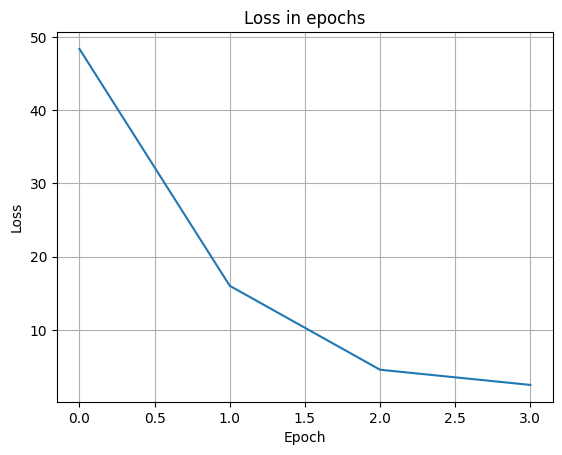

Accuracy of the network on the test images: 94.4


In [ ]:
random.seed(31)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
params = {
    "model_name": "resnet50",
    "binary_classification": False,
    "adamW": True,

    "augmentation": True,
    "batch_train": 128,
    "batch_test": 500,
    "test_size": 1000,

    "lr": 0.003,
    "lr_backbone": 0.0001,
    "weight_decay": 0.001,
    "lr_decay": 0.2,
    "epochs": 4,
    "lr_step": 2,

    "tune_layers": ["fc"],
    "unfreeze_layers": ["layer4"],
    "freeze_epoch": 1
}


train_loader, test_loader = get_loaders(params)

model = get_model(params["model_name"], params["binary_classification"])

# show_grad_stat(model)

freeze(model, params["tune_layers"])

criterion = nn.CrossEntropyLoss()
# criterion = nn.MultiMarginLoss()

if params["adamW"]:
  optimizer = torch.optim.AdamW(
      [
          {"params": model.fc.parameters(), "lr": params["lr"], "weight_decay": params["weight_decay"]},
          {"params": [param for name, param in model.named_parameters() if 'fc' not in name], "lr": params["lr_backbone"],
          "weight_decay": params["weight_decay"]},
      ]
  )

else:
  optimizer = torch.optim.Adam(
      [
          {"params": model.fc.parameters(), "lr": params["lr"], "weight_decay": params["weight_decay"]},
          {"params": [param for name, param in model.named_parameters() if 'fc' not in name], "lr": params["lr_backbone"],
          "weight_decay": params["weight_decay"]},
      ]
  )


scheduler = StepLR(optimizer, step_size=params["lr_step"], gamma=params["lr_decay"])
# scheduler = CyclicLR(optimizer, base_lr=0.0006, max_lr=0.003, step_size_up=4*len(train_loader), mode='triangular', cycle_momentum=False)


train_model(model, train_loader, criterion, optimizer, scheduler, params, test_loader)
acc = evaluate_model(model, test_loader)

save_params(params, acc)


# If you get size error while calculating accuracy

In [ ]:
random.seed(31)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
params = {
    "model_name": "resnet50",
    "binary_classification": False,
    "adamW": False,

    "augmentation": False,
    "batch_train": 128,
    "batch_test": 200,
    "test_size": 1000,

    "lr": 0.003,
    "lr_backbone": 0.0001,
    "weight_decay": 0.001,
    "lr_decay": 0.2,
    "epochs": 4,
    "lr_step": 2,

    "tune_layers": ["fc", "bn"],
    "unfreeze_layers": [],
    "freeze_epoch": 1
}


train_loader, test_loader = get_loaders(params)
acc = evaluate_model(model, test_loader)

Accuracy of the network on the test images: 93.1


In [ ]:
acc = evaluate_model(model, train_loader)

Accuracy of the network on the test images: 96.70814301464797


In [ ]:
model = resnet101()
freeze(model, params["tune_layers"])
for name, i in model.named_parameters():
  print(name, " ", i.requires_grad)

conv1.weight   False
bn1.weight   True
bn1.bias   True
layer1.0.conv1.weight   False
layer1.0.bn1.weight   True
layer1.0.bn1.bias   True
layer1.0.conv2.weight   False
layer1.0.bn2.weight   True
layer1.0.bn2.bias   True
layer1.0.conv3.weight   False
layer1.0.bn3.weight   True
layer1.0.bn3.bias   True
layer1.0.downsample.0.weight   False
layer1.0.downsample.1.weight   False
layer1.0.downsample.1.bias   False
layer1.1.conv1.weight   False
layer1.1.bn1.weight   True
layer1.1.bn1.bias   True
layer1.1.conv2.weight   False
layer1.1.bn2.weight   True
layer1.1.bn2.bias   True
layer1.1.conv3.weight   False
layer1.1.bn3.weight   True
layer1.1.bn3.bias   True
layer1.2.conv1.weight   False
layer1.2.bn1.weight   True
layer1.2.bn1.bias   True
layer1.2.conv2.weight   False
layer1.2.bn2.weight   True
layer1.2.bn2.bias   True
layer1.2.conv3.weight   False
layer1.2.bn3.weight   True
layer1.2.bn3.bias   True
layer2.0.conv1.weight   False
layer2.0.bn1.weight   True
layer2.0.bn1.bias   True
layer2.0.conv2.w